In [1]:
%load_ext autoreload
%autoreload 2

In [40]:
import transformers
from transformers import AutoTokenizer, AutoModelForTokenClassification
from datasets import load_dataset, Dataset
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix, binary_f1_score
from copy import deepcopy, copy
import seaborn as sns
import pandas as pd

from few_shot_learning_nlp.few_shot_ner_image_documents.bio_technique import BioTrainer
from few_shot_learning_nlp.few_shot_ner_image_documents.image_dataset import ImageLayoutDataset
from few_shot_learning_nlp.few_shot_ner_image_documents.bio_technique_dataset import generate_dataset

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Loading FUNSD Dataset

In [5]:
funsd_dataset = load_dataset("nielsr/funsd",
                             cache_dir = "/Data/pedro.silva/")

/users/eleves-a/2022/pedro.silva/few-shot-learning-transformers/.venv/lib64/python3.9/site-packages/datasets/load.py:1429: FutureWarning: The repository for nielsr/funsd contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/nielsr/funsd
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [7]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased",
                                          cache_dir = "/Data/pedro.silva")

In [9]:
l = funsd_dataset['train'].features['ner_tags'].feature.names

In [10]:
idx2label = {}
for k, v in enumerate(l):
    if v == 'O':
        idx2label[k] = "none"

    else:
        idx2label[k] = v.split('-')[1].lower() 

In [36]:
label_names =["header", "question", "answer", "none"]
n_classes= len(label_names)

In [12]:
tokenizer.sep_token

'[SEP]'

## Running model without line split

### 2 Shots

Generate dataset will generate n_shots * num_classes samples in the following format

`{`

`words: [target_word, SEP, word_1, ..., word_n]`

`ner_tags: [1, -100, class of word 1 == target_word, ..., class of word n == target_word]`

`}` 


In [27]:
train_data = generate_dataset(
    funsd_dataset['train'],
    label_names,
    idx2label,
    tokenizer,
    n_shots=2,
)

val_data = generate_dataset(
    Dataset.from_dict(funsd_dataset['train'][10:]),
    label_names,
    idx2label,
    tokenizer,
    n_shots=50,
)

test_data = generate_dataset(
    funsd_dataset['test'],
    label_names,
    idx2label,
    tokenizer,
    n_shots = np.inf,
)

In [46]:
train_data.to_pandas()

,ner_tags,words,bboxes
0,"[1, -100, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[header, [SEP], R&D, :, Suggestion:, Date:, Li...","[[0, 0, 0, 0], [0, 0, 0, 0], [383, 91, 493, 17..."
1,"[1, -100, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, ...","[question, [SEP], R&D, :, Suggestion:, Date:, ...","[[0, 0, 0, 0], [0, 0, 0, 0], [383, 91, 493, 17..."
2,"[1, -100, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[answer, [SEP], R&D, :, Suggestion:, Date:, Li...","[[0, 0, 0, 0], [0, 0, 0, 0], [383, 91, 493, 17..."
3,"[1, -100, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[none, [SEP], R&D, :, Suggestion:, Date:, Lice...","[[0, 0, 0, 0], [0, 0, 0, 0], [383, 91, 493, 17..."
4,"[1, -100, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ...","[header, [SEP], Brand:, Style:, PHOENIX, Compa...","[[0, 0, 0, 0], [0, 0, 0, 0], [99, 129, 154, 13..."
5,"[1, -100, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, ...","[question, [SEP], Brand:, Style:, PHOENIX, Com...","[[0, 0, 0, 0], [0, 0, 0, 0], [99, 129, 154, 13..."
6,"[1, -100, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, ...","[answer, [SEP], Brand:, Style:, PHOENIX, Compa...","[[0, 0, 0, 0], [0, 0, 0, 0], [99, 129, 154, 13..."
7,"[1, -100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[none, [SEP], Brand:, Style:, PHOENIX, Company...","[[0, 0, 0, 0], [0, 0, 0, 0], [99, 129, 154, 13..."


In [29]:
train_dataset = ImageLayoutDataset(
    train_data,
    tokenizer    
)

train_dataloader = DataLoader(
    train_dataset,
    shuffle=False
)

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 113.12it/s]


In [30]:
validation_dataset = ImageLayoutDataset(
    val_data,
    tokenizer    
)

validation_dataloader = DataLoader(
    validation_dataset,
    shuffle=False,
    batch_size= 4
)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:01<00:00, 168.88it/s]


In [31]:
test_dataset = ImageLayoutDataset(
    test_data,
    tokenizer    
)

test_dataloader = DataLoader(
    test_dataset,
    shuffle=False,
    batch_size= 4
)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:01<00:00, 145.66it/s]


In [37]:
model = AutoModelForTokenClassification.from_pretrained(
    "bert-base-uncased",
    cache_dir = "/Data/pedro.silva/",
    num_labels = 2
)
model.to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr = 1e-5
)

trainer = BioTrainer(
    model,
    optimizer,
    n_classes
)

history = trainer.train(
    train_dataloader, 
    validation_dataloader,
    n_epochs = 100
)

100%|██████████| 100/100 [04:29<00:00,  2.69s/it]

f1-score : 0.5489790439605713
tensor([[  13,   22,   24,    7],
        [ 305, 1907,  892,  457],
        [ 180,  649, 2036,  697],
        [   5,    5,   26,   23]], device='cuda:0')


In [38]:
best_f1, best_epoch = np.max(history), np.argmax(history)

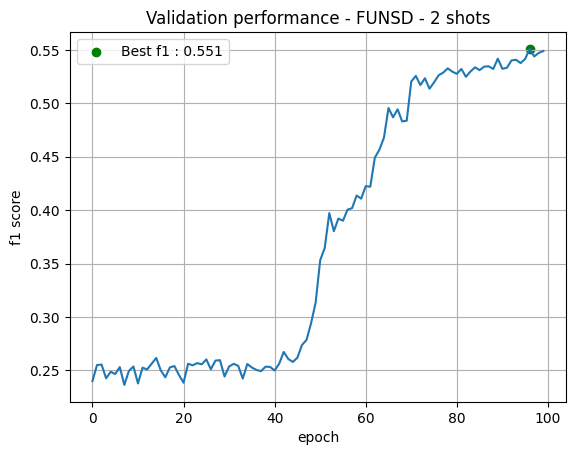

In [39]:
plt.plot(history)
plt.scatter(
    [best_epoch],
    [best_f1],
    color = "green",
    label = f"Best f1 : {round(best_f1,3)}"
)
plt.legend()
plt.ylabel("f1 score")
plt.xlabel("epoch")
plt.title("Validation performance - FUNSD - 2 shots")
plt.grid()

In [42]:
y_pred, y_true = trainer.test(
    test_dataloader
)

100%|██████████| 50/50 [00:02<00:00, 23.01it/s]


In [43]:
f1 = multiclass_f1_score(
    y_pred.to(torch.int64),
    y_true.to(torch.int64),
    num_classes = n_classes
)


conf_matrix = multiclass_confusion_matrix(
    y_pred.to(torch.int64),
    y_true.to(torch.int64),
    num_classes = n_classes
)


In [45]:
f1

tensor(0.5072, device='cuda:0')